In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer

In [50]:
PATH_DATA = '../data/data/'
PATH_IMAGES = '../assets/images/confusion/'
PATH_RESULTS = '../results/'

## Loading the data

In [218]:
# training set
train = pd.read_csv(PATH_DATA + "CRC_3200_train.csv")
X_train = train[['named_entities']].copy()
y_bin_train = train['bin_tag'].copy()

In [219]:
# test set (CRC)
test_CRC = pd.read_csv(PATH_DATA + "CRC_800_test.csv")
X_test_CRC = test_CRC[['named_entities']].copy()
y_test_bin_CRC = test_CRC['bin_tag'].copy()

In [220]:
# test set (C3)
test_c3 = pd.read_csv(PATH_DATA + "C3_12000.csv")
X_test_c3 = test_c3[['named_entities']].copy()
y_test_bin_c3 = test_c3['bin_tag'].copy()

In [221]:
# test set (YNACC)
test_ynacc = pd.read_csv(PATH_DATA + "YNACC.csv")
X_test_ynacc = test_ynacc[['named_entities']].copy()
X_test_ynacc.fillna(0, inplace=True)
y_test_bin_ynacc = test_ynacc['bin_tag'].copy()

## Gradient Boosting

In [222]:
clf = GradientBoostingClassifier(n_estimators=300,
                                  learning_rate=0.03,
                                  max_depth=8,
                                  validation_fraction=0.1,
                                  n_iter_no_change=5, tol=0.005,
                                  random_state=0,
                                  verbose=1)

### All features - Multiclass

In [159]:
trans = ColumnTransformer(transformers=[
            #('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'text_review'),
            ('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,1)), 'text_pos'),
            ],
                         remainder='drop')

In [160]:
pipeline = Pipeline([
    ('union', trans)
])

In [161]:
X_train_fitted = pipeline.fit_transform(X_train)
X_test_CRC_fitted = pipeline.transform(X_test_CRC)
X_test_c3_fitted = pipeline.transform(X_test_c3)
X_test_ynacc_fitted = pipeline.transform(X_test_ynacc)

print('Size of the feature matrix for CRC:', X_test_CRC_fitted.shape)
print('Size of the feature matrix for C3:', X_test_c3_fitted.shape)
print('Size of the feature matrix for YNACC:', X_test_ynacc_fitted.shape)

Size of the feature matrix for CRC: (800, 35)
Size of the feature matrix for C3: (12000, 35)
Size of the feature matrix for YNACC: (22795, 35)


In [223]:
clf.fit(X_train, y_bin_train)

      Iter       Train Loss   Remaining Time 
         1           1.3841            0.35s
         2           1.3829            0.63s
         3           1.3818            0.71s
         4           1.3807            0.65s
         5           1.3798            0.60s
         6           1.3788            0.56s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=8,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.005,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

Accuracy: 0.543
F1 Score: 0.3821762799740765
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      5484
         1.0       0.54      1.00      0.70      6516

    accuracy                           0.54     12000
   macro avg       0.27      0.50      0.35     12000
weighted avg       0.29      0.54      0.38     12000



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


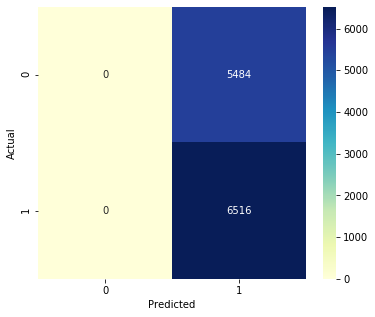

In [226]:
y_pred = clf.predict(X_test_c3)
print("Accuracy:", accuracy_score(y_test_bin_c3, y_pred))
print("F1 Score:", f1_score(y_test_bin_c3, y_pred, average='weighted'))
print(classification_report(y_test_bin_c3, y_pred))
report = classification_report(y_test_bin_c3, y_pred, output_dict=True)
pd.DataFrame(report).transpose().to_csv(PATH_RESULTS+'bin-GBM-C3-entities.csv', index=False)

conf_mat = confusion_matrix(y_test_bin_c3, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(PATH_IMAGES+'bin-GBM-C3-entities.png', bbox_inches='tight')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ee86a90>]],
      dtype=object)

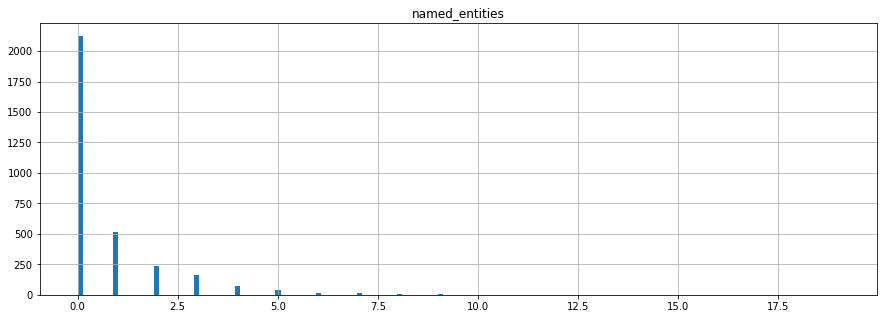

In [235]:
discourse = train[['named_entities']].copy()
discourse.hist(figsize=(15,5), bins=150)